In [136]:
! pip install lazypredict
!pip install jupyter_contrib_nbextensions
!jupyter contrib nbextension install --user
!pip install jupyter_nbextensions_configurator
!jupyter nbextensions_configurator enable --user

Config option `kernel_spec_manager_class` not recognized by `EnableJupyterNbextensionsConfiguratorApp`.
Enabling: jupyter_nbextensions_configurator
- Writing config: /home/shivam/.jupyter
    - Validating...
      jupyter_nbextensions_configurator 0.6.1 OK
Enabling notebook nbextension nbextensions_configurator/config_menu/main...
Enabling tree nbextension nbextensions_configurator/tree_tab/main...


In [1]:
import pandas as pd
import numpy as np
import os
import time
import glob
from random import sample

from scipy.io import wavfile, savemat
from scipy.fft import fft, fftfreq
from scipy import signal
from scipy.fft import fftshift
from scipy.io import loadmat
from sklearn.model_selection import train_test_split

from IPython.display import Audio, display
from IPython.display import clear_output

import librosa
import mne
import pymatreader
import yasa
import seaborn as sns
import pyxdf

from mne.time_frequency import psd_array_multitaper
from mne.decoding import CSP
from scipy.integrate import simps
from yasa import sliding_window
from lazypredict.Supervised import LazyClassifier

import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

/home/shivam/anaconda3/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/home/shivam/anaconda3/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package yasa is out of date. Your version is 0.6.1, the latest is 0.6.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
# CNN packages
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import SGD,RMSprop,Adam
from keras.utils import np_utils
from keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout, Softmax
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

2023-01-17 17:35:42.499380: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-17 17:35:42.621677: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-17 17:35:42.648040: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-17 17:35:43.170195: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [3]:
# Set gpu as backend
import tensorflow as tf
import keras
config = tf.compat.v1.ConfigProto()
sess = tf.compat.v1.Session(config=config)
keras.backend.set_session(sess)

2023-01-17 17:35:43.561960: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-17 17:35:44.184817: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3375 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:65:00.0, compute capability: 7.5


In [4]:
# https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score

# Grasp open and close vs non-grasp

In [165]:
os.chdir("/mnt/sda1/shivam/Thesis/Grasp Experiment/Data/PreprocessedData/Preprocessedv2")
os.getcwd()

'/mnt/sda1/shivam/Thesis/Grasp Experiment/Data/PreprocessedData/Preprocessedv2'

In [166]:
files = glob.glob("*.set")
files

['P01.set', 'P03.set', 'P04.set', 'P02.set']

In [208]:
def get_trials():
    trial_ctr_dict = {}
    for x in events[1].keys():
        if "ActionBeg" in x:
            trial_ctr_dict[x[10:]] = 0
    return trial_ctr_dict

In [209]:
def save_time_series_as_df(event_time, eeg_data, file_name):
    eeg_df = []
    channels = np.array([[x] for x in arr.ch_names])
    trial_ctr_dict = get_trials()
    for ts in range(len(event_time["Name"])):
        p_eeg  = eeg_data.iloc[event_time["StartTime"][ts]: event_time["StartTime"][ts] + 250, 1:].T
        handPos = np.array([[event_time["handPos"][ts]]] * 64)
        Hand = np.array([[event_time["Hand"][ts]]] * 64)
        Action = np.array([[event_time["Action"][ts]]] * 64)
        Subject = np.array([[file_name[:-4]]] * 64)
        Event = np.array([[event_time["Event"][ts]]] * 64)
        
        trial_type = event_time["handPos"][ts] + "-" + event_time["Hand"][ts] + "-" + event_time["Action"][ts]
        trial_ctr_dict[trial_type] += 1
        Trial = np.array([[trial_ctr_dict[trial_type]]] * 64)

        p_eeg = np.append(p_eeg, handPos, axis=1)
        p_eeg = np.append(p_eeg, Hand, axis=1)
        p_eeg = np.append(p_eeg, Action, axis=1)
        p_eeg = np.append(p_eeg, Subject, axis=1)
        p_eeg = np.append(p_eeg, channels, axis=1)
        p_eeg = np.append(p_eeg, Trial, axis=1)
        p_eeg = np.append(p_eeg, Event, axis=1)
        
        if len(eeg_df) == 0:
            eeg_df = p_eeg
        else: 
            try:
                eeg_df = np.concatenate((eeg_df, p_eeg), axis=0)
            except:
                pass
        print(eeg_df.shape)

    return eeg_df 

In [210]:
def get_event_info(marker_stream):
    # Get event info
    event_time = {"Name": [], "StartTime": [], "EndTime": [], "handPos": [], "Hand": [], "Action": [], "Event": []}
    for idx in range(len(marker_stream[0])):
        marker_list = marker_stream[0][idx][2]
        marker = list(marker_stream[1].keys())[list(marker_stream[1].values()).index(marker_list)]
        if "Free" in marker:
            return event_time
        if "ActionBeg" in marker or "FixBeg" in marker:
            start_time = marker_stream[0][idx][0]
            end_time = marker_stream[0][idx+1][0]
            action_name = marker.split("-")

            event_time["Name"].append(action_name)
            event_time["StartTime"].append(start_time)
            event_time["EndTime"].append(end_time)
            event_time["Event"].append(action_name[0])
            event_time["handPos"].append(action_name[1])
            event_time["Hand"].append(action_name[2])
            event_time["Action"].append(action_name[3])
            
    return event_time

In [211]:
os.chdir("/mnt/sda1/shivam/Thesis/Grasp Experiment/Data/PreprocessedData/Preprocessedv2")
print("Current directory: ", os.getcwd())
data_files = glob.glob("*.set")
print("Files in current directory: ", data_files)
eeg_df_main = []
for file_name in data_files:
    print("Current file: ", file_name)
    arr = mne.io.read_raw_eeglab(file_name)
    eeg_data = arr.to_data_frame()
    events = mne.events_from_annotations(arr)
    event_time = get_event_info(events)
    eeg_df = save_time_series_as_df(event_time, eeg_data, file_name)
    
    if len(eeg_df_main) == 0:
        eeg_df_main = eeg_df
    else: 
        eeg_df_main = np.concatenate((eeg_df_main, eeg_df), axis=0)
    print(eeg_df_main.shape)

Current directory:  /mnt/sda1/shivam/Thesis/Grasp Experiment/Data/PreprocessedData/Preprocessedv2
Files in current directory:  ['P01.set', 'P03.set', 'P04.set', 'P02.set']
Current file:  P01.set
Reading /mnt/sda1/shivam/Thesis/Grasp Experiment/Data/PreprocessedData/Preprocessedv2/P01.fdt
Used Annotations descriptions: ['ActionBeg-palmDown-Left-Close', 'ActionBeg-palmDown-Left-Open', 'ActionBeg-palmDown-Right-Close', 'ActionBeg-palmDown-Right-Open', 'ActionBeg-palmIn-Left-Close', 'ActionBeg-palmIn-Left-Open', 'ActionBeg-palmIn-Right-Close', 'ActionBeg-palmIn-Right-Open', 'ActionBeg-palmUp-Left-Close', 'ActionBeg-palmUp-Left-Open', 'ActionBeg-palmUp-Right-Close', 'ActionBeg-palmUp-Right-Open', 'ActionEnd-palmDown-Left-Close', 'ActionEnd-palmDown-Left-Open', 'ActionEnd-palmDown-Right-Close', 'ActionEnd-palmDown-Right-Open', 'ActionEnd-palmIn-Left-Close', 'ActionEnd-palmIn-Left-Open', 'ActionEnd-palmIn-Right-Close', 'ActionEnd-palmIn-Right-Open', 'ActionEnd-palmUp-Left-Close', 'ActionEnd-p

(32256, 257)
(32320, 257)
(32384, 257)
(32448, 257)
(32512, 257)
(32576, 257)
(32640, 257)
(32704, 257)
(32768, 257)
(32832, 257)
(32896, 257)
(32960, 257)
(33024, 257)
(33088, 257)
(33152, 257)
(33216, 257)
(33280, 257)
(33344, 257)
(33408, 257)
(33472, 257)
(33536, 257)
(33600, 257)
(33664, 257)
(33728, 257)
(33792, 257)
(33856, 257)
(33920, 257)
(33984, 257)
(34048, 257)
(34112, 257)
(34176, 257)
(34240, 257)
(34304, 257)
(34368, 257)
(34432, 257)
(34496, 257)
(34560, 257)
(34624, 257)
(34688, 257)
(34752, 257)
(34816, 257)
(34880, 257)
(34944, 257)
(35008, 257)
(35072, 257)
(35136, 257)
(35200, 257)
(35264, 257)
(35328, 257)
(35392, 257)
(35456, 257)
(35520, 257)
(35584, 257)
(35648, 257)
(35712, 257)
(35776, 257)
(35840, 257)
(35904, 257)
(35968, 257)
(36032, 257)
(36096, 257)
(36160, 257)
(36224, 257)
(36288, 257)
(36352, 257)
(36416, 257)
(36480, 257)
(36544, 257)
(36608, 257)
(36672, 257)
(36736, 257)
(36800, 257)
(36864, 257)
(36928, 257)
(36992, 257)
(37056, 257)
(37120, 257)

(3392, 257)
(3456, 257)
(3520, 257)
(3584, 257)
(3648, 257)
(3712, 257)
(3776, 257)
(3840, 257)
(3904, 257)
(3968, 257)
(4032, 257)
(4096, 257)
(4160, 257)
(4224, 257)
(4288, 257)
(4352, 257)
(4416, 257)
(4480, 257)
(4544, 257)
(4608, 257)
(4672, 257)
(4736, 257)
(4800, 257)
(4864, 257)
(4928, 257)
(4992, 257)
(5056, 257)
(5120, 257)
(5184, 257)
(5248, 257)
(5312, 257)
(5376, 257)
(5440, 257)
(5504, 257)
(5568, 257)
(5632, 257)
(5696, 257)
(5760, 257)
(5824, 257)
(5888, 257)
(5952, 257)
(6016, 257)
(6080, 257)
(6144, 257)
(6208, 257)
(6272, 257)
(6336, 257)
(6400, 257)
(6464, 257)
(6528, 257)
(6592, 257)
(6656, 257)
(6720, 257)
(6784, 257)
(6848, 257)
(6912, 257)
(6976, 257)
(7040, 257)
(7104, 257)
(7168, 257)
(7232, 257)
(7296, 257)
(7360, 257)
(7424, 257)
(7488, 257)
(7552, 257)
(7616, 257)
(7680, 257)
(7744, 257)
(7808, 257)
(7872, 257)
(7936, 257)
(8000, 257)
(8064, 257)
(8128, 257)
(8192, 257)
(8256, 257)
(8320, 257)
(8384, 257)
(8448, 257)
(8512, 257)
(8576, 257)
(8640, 257)
(870

(44288, 257)
(44352, 257)
(44416, 257)
(44480, 257)
(44544, 257)
(44608, 257)
(44672, 257)
(44736, 257)
(44800, 257)
(44864, 257)
(44928, 257)
(44992, 257)
(45056, 257)
(45120, 257)
(45184, 257)
(45248, 257)
(45312, 257)
(45376, 257)
(45440, 257)
(45504, 257)
(45568, 257)
(45632, 257)
(45696, 257)
(45760, 257)
(45824, 257)
(45888, 257)
(45952, 257)
(46016, 257)
(46080, 257)
(46144, 257)
(46208, 257)
(46272, 257)
(46336, 257)
(46400, 257)
(46464, 257)
(46528, 257)
(46592, 257)
(46656, 257)
(46720, 257)
(46784, 257)
(46848, 257)
(46912, 257)
(46976, 257)
(47040, 257)
(47104, 257)
(47168, 257)
(47232, 257)
(47296, 257)
(47360, 257)
(47424, 257)
(47488, 257)
(47552, 257)
(47616, 257)
(47680, 257)
(47744, 257)
(47808, 257)
(47872, 257)
(47936, 257)
(48000, 257)
(48064, 257)
(48128, 257)
(48192, 257)
(48256, 257)
(48320, 257)
(48384, 257)
(48448, 257)
(48512, 257)
(48576, 257)
(48640, 257)
(48704, 257)
(48768, 257)
(48832, 257)
(48896, 257)
(48960, 257)
(49024, 257)
(49088, 257)
(49152, 257)

(15808, 257)
(15872, 257)
(15936, 257)
(16000, 257)
(16064, 257)
(16128, 257)
(16192, 257)
(16256, 257)
(16320, 257)
(16384, 257)
(16448, 257)
(16512, 257)
(16576, 257)
(16640, 257)
(16704, 257)
(16768, 257)
(16832, 257)
(16896, 257)
(16960, 257)
(17024, 257)
(17088, 257)
(17152, 257)
(17216, 257)
(17280, 257)
(17344, 257)
(17408, 257)
(17472, 257)
(17536, 257)
(17600, 257)
(17664, 257)
(17728, 257)
(17792, 257)
(17856, 257)
(17920, 257)
(17984, 257)
(18048, 257)
(18112, 257)
(18176, 257)
(18240, 257)
(18304, 257)
(18368, 257)
(18432, 257)
(18496, 257)
(18560, 257)
(18624, 257)
(18688, 257)
(18752, 257)
(18816, 257)
(18880, 257)
(18944, 257)
(19008, 257)
(19072, 257)
(19136, 257)
(19200, 257)
(19264, 257)
(19328, 257)
(19392, 257)
(19456, 257)
(19520, 257)
(19584, 257)
(19648, 257)
(19712, 257)
(19776, 257)
(19840, 257)
(19904, 257)
(19968, 257)
(20032, 257)
(20096, 257)
(20160, 257)
(20224, 257)
(20288, 257)
(20352, 257)
(20416, 257)
(20480, 257)
(20544, 257)
(20608, 257)
(20672, 257)

(154816, 257)
Current file:  P02.set
Reading /mnt/sda1/shivam/Thesis/Grasp Experiment/Data/PreprocessedData/Preprocessedv2/P02.fdt
Used Annotations descriptions: ['ActionBeg-palmDown-Left-Close', 'ActionBeg-palmDown-Left-Open', 'ActionBeg-palmDown-Right-Close', 'ActionBeg-palmDown-Right-Open', 'ActionBeg-palmIn-Left-Close', 'ActionBeg-palmIn-Left-Open', 'ActionBeg-palmIn-Right-Close', 'ActionBeg-palmIn-Right-Open', 'ActionBeg-palmUp-Left-Close', 'ActionBeg-palmUp-Left-Open', 'ActionBeg-palmUp-Right-Close', 'ActionBeg-palmUp-Right-Open', 'ActionEnd-palmDown-Left-Close', 'ActionEnd-palmDown-Left-Open', 'ActionEnd-palmDown-Right-Close', 'ActionEnd-palmDown-Right-Open', 'ActionEnd-palmIn-Left-Close', 'ActionEnd-palmIn-Left-Open', 'ActionEnd-palmIn-Right-Close', 'ActionEnd-palmIn-Right-Open', 'ActionEnd-palmUp-Left-Close', 'ActionEnd-palmUp-Left-Open', 'ActionEnd-palmUp-Right-Close', 'ActionEnd-palmUp-Right-Open', 'ExptEnd', 'FixBeg-palmDown-Left-Close', 'FixBeg-palmDown-Left-Open', 'FixBeg

(32960, 257)
(33024, 257)
(33088, 257)
(33152, 257)
(33216, 257)
(33280, 257)
(33344, 257)
(33408, 257)
(33472, 257)
(33536, 257)
(33600, 257)
(33664, 257)
(33728, 257)
(33792, 257)
(33856, 257)
(33920, 257)
(33984, 257)
(34048, 257)
(34112, 257)
(34176, 257)
(34240, 257)
(34304, 257)
(34368, 257)
(34432, 257)
(34496, 257)
(34560, 257)
(34624, 257)
(34688, 257)
(34752, 257)
(34816, 257)
(34880, 257)
(34944, 257)
(35008, 257)
(35072, 257)
(35136, 257)
(35200, 257)
(35264, 257)
(35328, 257)
(35392, 257)
(35456, 257)
(35520, 257)
(35584, 257)
(35648, 257)
(35712, 257)
(35776, 257)
(35840, 257)
(35904, 257)
(35968, 257)
(36032, 257)
(36096, 257)
(36160, 257)
(36224, 257)
(36288, 257)
(36352, 257)
(36416, 257)
(36480, 257)
(36544, 257)
(36608, 257)
(36672, 257)
(36736, 257)
(36800, 257)
(36864, 257)
(36928, 257)
(36992, 257)
(37056, 257)
(37120, 257)
(37184, 257)
(37248, 257)
(37312, 257)
(37376, 257)
(37440, 257)
(37504, 257)
(37568, 257)
(37632, 257)
(37696, 257)
(37760, 257)
(37824, 257)

In [212]:
eeg_df_main[70][-10:]

array(['3.649890661239624', '5.605170726776123', '7.704970359802247',
       'palmDown', 'Right', 'Open', 'P01', 'E7', '2', 'ActionBeg'],
      dtype='<U32')

In [9]:
# df = pd.DataFrame(eeg_df_main, columns=list(range(1, 1001, 4))+["handPos", "Hand", "Action", "Subject", "Channel", "Trial", "Event"])
os.chdir("/mnt/sda1/shivam/Thesis/Grasp Experiment/Data/CleanSep/")
dataset.to_csv("cleaned_datav6.csv", index=False, header=list(range(0, 1000, 4))+["handPos", "Hand", "Action", "Subject", "Channel", "Trial", "Event"])
dataset

,0,4,8,12,16,20,24,28,32,36,...,988,992,996,handPos,Hand,Action,Subject,Channel,Trial,Event
0,-1.90,-1.99,-1.78,-1.62,-1.48,-0.91,0.39,2.08,3.40,3.91,...,-7.72,-7.24,-7.80,palmDown,Right,Open,P01,E1,1,FixBeg
1,-7.51,-5.83,-4.00,-3.09,-3.17,-3.15,-1.89,0.57,3.00,4.20,...,-2.64,-3.55,-4.66,palmDown,Right,Open,P01,E2,1,FixBeg
2,-9.91,-7.74,-5.64,-4.76,-5.20,-5.92,-5.67,-4.04,-1.77,0.03,...,-4.12,-3.06,-2.08,palmDown,Right,Open,P01,E3,1,FixBeg
3,-2.90,-2.37,-2.57,-3.16,-3.55,-3.28,-2.27,-0.88,0.37,1.04,...,-8.32,-7.22,-5.20,palmDown,Right,Open,P01,E4,1,FixBeg
4,-12.65,-9.81,-6.71,-5.26,-5.40,-5.29,-3.39,-0.24,2.04,1.91,...,6.35,6.56,6.00,palmDown,Right,Open,P01,E5,1,FixBeg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216251,1.73,3.25,3.93,3.44,2.25,1.21,0.84,1.17,1.81,2.32,...,1.13,0.90,0.06,palmIn,Right,Close,P02,E60,80,ActionBeg
216252,5.23,3.89,2.31,1.32,1.27,1.72,1.93,1.60,1.08,0.88,...,0.38,-0.45,-1.05,palmIn,Right,Close,P02,E61,80,ActionBeg
216253,6.82,5.31,3.60,2.73,3.00,3.74,4.00,3.47,2.69,2.42,...,-1.19,-1.60,-2.05,palmIn,Right,Close,P02,E62,80,ActionBeg
216254,7.18,8.44,8.93,8.95,8.97,9.30,10.09,11.40,13.02,14.29,...,-0.56,-0.65,-1.01,palmIn,Right,Close,P02,E63,80,ActionBeg


In [10]:
os.chdir("/mnt/sda1/shivam/Thesis/Grasp Experiment/Data/CleanSep/")
dataset = pd.read_csv("cleaned_datav6.csv")
dataset

,0,4,8,12,16,20,24,28,32,36,...,988,992,996,handPos,Hand,Action,Subject,Channel,Trial,Event
0,-1.90,-1.99,-1.78,-1.62,-1.48,-0.91,0.39,2.08,3.40,3.91,...,-7.72,-7.24,-7.80,palmDown,Right,Open,P01,E1,1,FixBeg
1,-7.51,-5.83,-4.00,-3.09,-3.17,-3.15,-1.89,0.57,3.00,4.20,...,-2.64,-3.55,-4.66,palmDown,Right,Open,P01,E2,1,FixBeg
2,-9.91,-7.74,-5.64,-4.76,-5.20,-5.92,-5.67,-4.04,-1.77,0.03,...,-4.12,-3.06,-2.08,palmDown,Right,Open,P01,E3,1,FixBeg
3,-2.90,-2.37,-2.57,-3.16,-3.55,-3.28,-2.27,-0.88,0.37,1.04,...,-8.32,-7.22,-5.20,palmDown,Right,Open,P01,E4,1,FixBeg
4,-12.65,-9.81,-6.71,-5.26,-5.40,-5.29,-3.39,-0.24,2.04,1.91,...,6.35,6.56,6.00,palmDown,Right,Open,P01,E5,1,FixBeg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216251,1.73,3.25,3.93,3.44,2.25,1.21,0.84,1.17,1.81,2.32,...,1.13,0.90,0.06,palmIn,Right,Close,P02,E60,80,ActionBeg
216252,5.23,3.89,2.31,1.32,1.27,1.72,1.93,1.60,1.08,0.88,...,0.38,-0.45,-1.05,palmIn,Right,Close,P02,E61,80,ActionBeg
216253,6.82,5.31,3.60,2.73,3.00,3.74,4.00,3.47,2.69,2.42,...,-1.19,-1.60,-2.05,palmIn,Right,Close,P02,E62,80,ActionBeg
216254,7.18,8.44,8.93,8.95,8.97,9.30,10.09,11.40,13.02,14.29,...,-0.56,-0.65,-1.01,palmIn,Right,Close,P02,E63,80,ActionBeg


In [11]:
grasp_labels = {"FixBeg": 0, "ActionBeg": 1}

In [14]:
# 64 channel EEG data with 500 samples

X, y = [], []
nchan = 64
# new_dataset = dataset[~(dataset["Subject"] == "P01")]
iterations = len(dataset) // nchan
for idx in range(iterations):
    start = idx * nchan
    end = (idx + 1) * nchan

    X.append(np.expand_dims(dataset.iloc[start: end, :-7], 2))
    y.append(grasp_labels[dataset.iloc[start, -1]])
#     print(len(X), len(y))

X = np.array(X)
y = np.array(y)
X.shape, y.shape

((3379, 64, 250, 1), (3379,))

# Grasp vs non-grasp [EEGNET]

In [15]:
X_train, X_eval, y_train, y_eval = train_test_split(X[:, :, 60:124, 0], y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train.shape, X_eval.shape, X_test.shape, y_train.shape, y_eval.shape, y_test.shape

((2162, 64, 64), (676, 64, 64), (541, 64, 64), (2162,), (676,), (541,))

In [16]:
X_train.shape

(2162, 64, 64)

In [64]:
# https://github.com/vlawhern/arl-eegmodels
def EEGNet(nb_classes, Chans = 64, Samples = 128, 
             dropoutRate = 0.7, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('sigmoid', name = 'sigmoid')(dense)
    
    return Model(inputs=input1, outputs=softmax)

model = EEGNet(1, 64, 64)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 8)         512       
                                                                 
 batch_normalization_12 (Bat  (None, 64, 64, 8)        32        
 chNormalization)                                                
                                                                 
 depthwise_conv2d_4 (Depthwi  (None, 1, 64, 16)        1024      
 seConv2D)                                                       
                                                                 
 batch_normalization_13 (Bat  (None, 1, 64, 16)        64        
 chNormalization)                                                
                                                           

In [65]:
model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics = ['accuracy'])

# count number of parameters in the model
numParams = model.count_params()    

# set a valid path for your system to record model checkpoints
checkpoint_filepath = "/tmp/checkpoint/"
checkpointer = ModelCheckpoint(
        filepath=checkpoint_filepath, 
        save_weights_only=True,
        monitor="val_accuracy",
        mode="max",
        save_best_only=True
)

# Handle class imbalance
class_weights = {0:1, 1:1}

In [66]:
################################################################################
# fit the model. Due to very small sample sizes this can get
# pretty noisy run-to-run, but most runs should be comparable to xDAWN + 
# Riemannian geometry classification (below)
################################################################################
batch_size = 512
EPOCHS = 200
history = model.fit(
    X_train, 
    y_train, 
    batch_size = batch_size, 
    epochs = EPOCHS, 
    validation_data=(X_eval, y_eval),
    callbacks=[checkpointer], 
#     class_weight = class_weights
)

Epoch 1/200
5/5 [==============================] - 1s 73ms/step - loss: 0.7300 - accuracy: 0.5014 - val_loss: 0.6927 - val_accuracy: 0.4956
Epoch 2/200
5/5 [==============================] - 0s 33ms/step - loss: 0.6932 - accuracy: 0.5176 - val_loss: 0.6910 - val_accuracy: 0.5178
Epoch 3/200
5/5 [==============================] - 0s 31ms/step - loss: 0.6894 - accuracy: 0.5412 - val_loss: 0.6895 - val_accuracy: 0.5251
Epoch 4/200
5/5 [==============================] - 0s 24ms/step - loss: 0.6855 - accuracy: 0.5453 - val_loss: 0.6880 - val_accuracy: 0.5207
Epoch 5/200
5/5 [==============================] - 0s 30ms/step - loss: 0.6822 - accuracy: 0.5652 - val_loss: 0.6862 - val_accuracy: 0.5340
Epoch 6/200
5/5 [==============================] - 0s 30ms/step - loss: 0.6776 - accuracy: 0.5786 - val_loss: 0.6842 - val_accuracy: 0.5399
Epoch 7/200
5/5 [==============================] - 0s 35ms/step - loss: 0.6732 - accuracy: 0.5911 - val_loss: 0.6820 - val_accuracy: 0.5473
Epoch 8/200
5/5 [===

5/5 [==============================] - 0s 24ms/step - loss: 0.5348 - accuracy: 0.7461 - val_loss: 0.5742 - val_accuracy: 0.6923
Epoch 118/200
5/5 [==============================] - 0s 24ms/step - loss: 0.5359 - accuracy: 0.7465 - val_loss: 0.5726 - val_accuracy: 0.6923
Epoch 119/200
5/5 [==============================] - 0s 22ms/step - loss: 0.5403 - accuracy: 0.7479 - val_loss: 0.5756 - val_accuracy: 0.6982
Epoch 120/200
5/5 [==============================] - 0s 23ms/step - loss: 0.5355 - accuracy: 0.7451 - val_loss: 0.5777 - val_accuracy: 0.6864
Epoch 121/200
5/5 [==============================] - 0s 26ms/step - loss: 0.5290 - accuracy: 0.7488 - val_loss: 0.5808 - val_accuracy: 0.6834
Epoch 122/200
5/5 [==============================] - 0s 25ms/step - loss: 0.5319 - accuracy: 0.7627 - val_loss: 0.5786 - val_accuracy: 0.6834
Epoch 123/200
5/5 [==============================] - 0s 23ms/step - loss: 0.5319 - accuracy: 0.7576 - val_loss: 0.5768 - val_accuracy: 0.6849
Epoch 124/200
5/5 [=

Epoch 175/200
5/5 [==============================] - 0s 26ms/step - loss: 0.5125 - accuracy: 0.7641 - val_loss: 0.5741 - val_accuracy: 0.6967
Epoch 176/200
5/5 [==============================] - 0s 25ms/step - loss: 0.5118 - accuracy: 0.7567 - val_loss: 0.5732 - val_accuracy: 0.6982
Epoch 177/200
5/5 [==============================] - 0s 23ms/step - loss: 0.5057 - accuracy: 0.7747 - val_loss: 0.5759 - val_accuracy: 0.6893
Epoch 178/200
5/5 [==============================] - 0s 26ms/step - loss: 0.5191 - accuracy: 0.7683 - val_loss: 0.5753 - val_accuracy: 0.6879
Epoch 179/200
5/5 [==============================] - 0s 25ms/step - loss: 0.5114 - accuracy: 0.7669 - val_loss: 0.5749 - val_accuracy: 0.6908
Epoch 180/200
5/5 [==============================] - 0s 24ms/step - loss: 0.5093 - accuracy: 0.7701 - val_loss: 0.5779 - val_accuracy: 0.6834
Epoch 181/200
5/5 [==============================] - 0s 23ms/step - loss: 0.5062 - accuracy: 0.7650 - val_loss: 0.5772 - val_accuracy: 0.7027
Epoch 

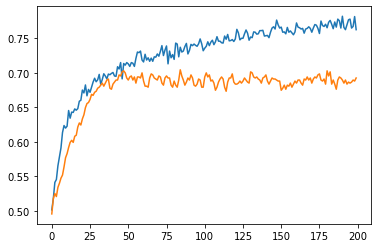

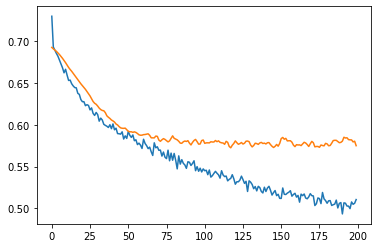

In [67]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

In [74]:
model.load_weights(checkpoint_filepath)
model_path = '/mnt/sda1/shivam/Thesis/Grasp Experiment/Data/Models/model-grasp-no-grasp-v1'
model.save(model_path)

26-Dec-22 10:41:40 | WARNING | Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


In [75]:
new_model = tf.keras.models.load_model(model_path)

# y_pred = np.argmax(new_model.predict(X_test), axis=1)  # Softmax
y_pred = [1 if x > 0.5 else 0 for x in new_model.predict(X_test)]  # Sigmoid

y_true = y_test
test_acc = sum(y_pred == y_true) / len(y_true)

print("Max train accuracy: ", max(history.history["accuracy"]))
print("Max validation accuracy: ", max(history.history["val_accuracy"]))
print(f'Test set accuracy: {test_acc:.0%}')

17/17 [==============================] - 0s 2ms/step
Max train accuracy:  0.781683623790741
Max validation accuracy:  0.7041420340538025
Test set accuracy: 69%


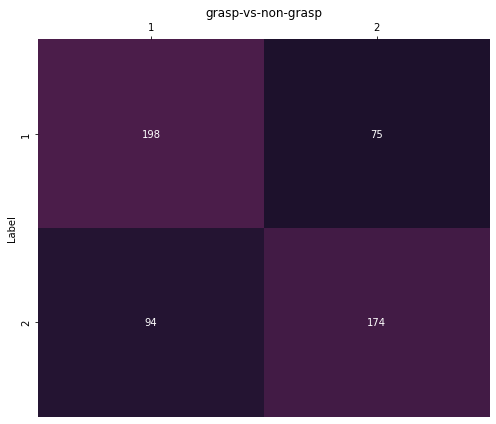

In [73]:
confusion_matrix = tf.math.confusion_matrix(y_true, y_pred)

plt.figure(figsize = (7,6))
hm1 = sns.heatmap(confusion_matrix, annot=True, cbar=False, vmin=0, vmax=1000,fmt='g')

hm1.set(title='grasp-vs-non-grasp', ylabel='Label')
hm1.xaxis.tick_top()

hm1.set_xticklabels([int(i.get_text())+1 for i in hm1.get_xticklabels()])
hm1.set_yticklabels([int(i.get_text())+1 for i in hm1.get_yticklabels()])
plt.tight_layout()

# hm1.get_figure().savefig(file_name + ".png")

# 3-class classification [open/close/no-grasp]

In [43]:
os.chdir("/mnt/sda1/shivam/Thesis/Grasp Experiment/Data/CleanSep/")
dataset = pd.read_csv("cleaned_datav6.csv")
dataset

,0,4,8,12,16,20,24,28,32,36,...,988,992,996,handPos,Hand,Action,Subject,Channel,Trial,Event
0,-1.90,-1.99,-1.78,-1.62,-1.48,-0.91,0.39,2.08,3.40,3.91,...,-7.72,-7.24,-7.80,palmDown,Right,Open,P01,E1,1,FixBeg
1,-7.51,-5.83,-4.00,-3.09,-3.17,-3.15,-1.89,0.57,3.00,4.20,...,-2.64,-3.55,-4.66,palmDown,Right,Open,P01,E2,1,FixBeg
2,-9.91,-7.74,-5.64,-4.76,-5.20,-5.92,-5.67,-4.04,-1.77,0.03,...,-4.12,-3.06,-2.08,palmDown,Right,Open,P01,E3,1,FixBeg
3,-2.90,-2.37,-2.57,-3.16,-3.55,-3.28,-2.27,-0.88,0.37,1.04,...,-8.32,-7.22,-5.20,palmDown,Right,Open,P01,E4,1,FixBeg
4,-12.65,-9.81,-6.71,-5.26,-5.40,-5.29,-3.39,-0.24,2.04,1.91,...,6.35,6.56,6.00,palmDown,Right,Open,P01,E5,1,FixBeg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216251,1.73,3.25,3.93,3.44,2.25,1.21,0.84,1.17,1.81,2.32,...,1.13,0.90,0.06,palmIn,Right,Close,P02,E60,80,ActionBeg
216252,5.23,3.89,2.31,1.32,1.27,1.72,1.93,1.60,1.08,0.88,...,0.38,-0.45,-1.05,palmIn,Right,Close,P02,E61,80,ActionBeg
216253,6.82,5.31,3.60,2.73,3.00,3.74,4.00,3.47,2.69,2.42,...,-1.19,-1.60,-2.05,palmIn,Right,Close,P02,E62,80,ActionBeg
216254,7.18,8.44,8.93,8.95,8.97,9.30,10.09,11.40,13.02,14.29,...,-0.56,-0.65,-1.01,palmIn,Right,Close,P02,E63,80,ActionBeg


In [44]:
grasp_labels = {"FixBeg": 0, "Open": 1, "Close": 2}

In [45]:
# 64 channel EEG data with 500 samples

X, y = [], []
nchan = 64
iterations = len(dataset) // nchan

for idx in range(iterations):
    start = idx * nchan
    end = (idx + 1) * nchan

    X.append(np.expand_dims(dataset.iloc[start: end, :-7], 2))
    if "ActionBeg" in dataset.iloc[start, -1]:
        y.append(grasp_labels[dataset.iloc[start, -5]])
    else:
        y.append(grasp_labels[dataset.iloc[start, -1]])
#     print(len(X), len(y))

X = np.array(X)
y = np.array(y)
X.shape, y.shape

((3379, 64, 250, 1), (3379,))

In [91]:
no_grasp = np.where(y == 0)[0]
no_grasp_to_use = np.array(sample(list(no_grasp), int(len(no_grasp) / 2)))
no_grasp_to_use.shape

(845,)

In [93]:
# New balanced dataset
Xb, yb = [], []
for idx in range(len(X)):
    if y[idx] == 0:
        if idx in no_grasp_to_use:
            Xb.append(X[idx])
            yb.append(y[idx])
    if y[idx] != 0:
        Xb.append(X[idx])
        yb.append(y[idx])

Xb = np.array(Xb)
yb = np.array(yb)
Xb.shape, yb.shape, np.unique(yb, return_counts=True)

((2534, 64, 250, 1), (2534,), (array([0, 1, 2]), array([845, 845, 844])))

In [48]:
np.unique(y, return_counts=True)

(array([0, 1, 2]), array([1690,  845,  844]))

In [94]:
X_train, X_eval, y_train, y_eval = train_test_split(Xb[:, :, 60:124, 0], yb, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train.shape, X_eval.shape, X_test.shape, y_train.shape, y_eval.shape, y_test.shape

((1621, 64, 64), (507, 64, 64), (406, 64, 64), (1621,), (507,), (406,))

In [102]:
# https://github.com/vlawhern/arl-eegmodels
def EEGNet(nb_classes, Chans = 64, Samples = 128, 
             dropoutRate = 0.7, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)

model = EEGNet(3, 64, 64)
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 8)         512       
                                                                 
 batch_normalization_24 (Bat  (None, 64, 64, 8)        32        
 chNormalization)                                                
                                                                 
 depthwise_conv2d_8 (Depthwi  (None, 1, 64, 16)        1024      
 seConv2D)                                                       
                                                                 
 batch_normalization_25 (Bat  (None, 1, 64, 16)        64        
 chNormalization)                                                
                                                           

In [103]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', 
              metrics = ['accuracy'])

# count number of parameters in the model
numParams = model.count_params()    

# set a valid path for your system to record model checkpoints
checkpoint_filepath = "/tmp/checkpoint/"
checkpointer = ModelCheckpoint(
        filepath=checkpoint_filepath, 
        save_weights_only=True,
        monitor="val_accuracy",
        mode="max",
        save_best_only=True
)

# Handle class imbalance
class_weights = {0:1, 1:2, 2:2}

In [109]:
################################################################################
# fit the model. Due to very small sample sizes this can get
# pretty noisy run-to-run, but most runs should be comparable to xDAWN + 
# Riemannian geometry classification (below)
################################################################################
batch_size = 512
EPOCHS = 200
history = model.fit(
    X_train, 
    y_train, 
    batch_size = batch_size, 
    epochs = EPOCHS, 
    validation_data=(X_eval, y_eval),
    callbacks=[checkpointer], 
#     class_weight = class_weights
)

Epoch 1/200
4/4 [==============================] - 0s 37ms/step - loss: 1.0063 - accuracy: 0.4830 - val_loss: 1.0270 - val_accuracy: 0.4931
Epoch 2/200
4/4 [==============================] - 0s 24ms/step - loss: 0.9993 - accuracy: 0.4923 - val_loss: 1.0263 - val_accuracy: 0.4892
Epoch 3/200
4/4 [==============================] - 0s 23ms/step - loss: 1.0088 - accuracy: 0.4843 - val_loss: 1.0241 - val_accuracy: 0.4892
Epoch 4/200
4/4 [==============================] - 0s 37ms/step - loss: 1.0049 - accuracy: 0.4917 - val_loss: 1.0212 - val_accuracy: 0.4990
Epoch 5/200
4/4 [==============================] - 0s 24ms/step - loss: 1.0050 - accuracy: 0.4756 - val_loss: 1.0190 - val_accuracy: 0.4931
Epoch 6/200
4/4 [==============================] - 0s 26ms/step - loss: 0.9913 - accuracy: 0.4978 - val_loss: 1.0184 - val_accuracy: 0.4832
Epoch 7/200
4/4 [==============================] - 0s 23ms/step - loss: 0.9980 - accuracy: 0.4781 - val_loss: 1.0196 - val_accuracy: 0.4872
Epoch 8/200
4/4 [===

4/4 [==============================] - 0s 23ms/step - loss: 0.9340 - accuracy: 0.5219 - val_loss: 1.0075 - val_accuracy: 0.4655
Epoch 118/200
4/4 [==============================] - 0s 24ms/step - loss: 0.9246 - accuracy: 0.5386 - val_loss: 1.0060 - val_accuracy: 0.4813
Epoch 119/200
4/4 [==============================] - 0s 26ms/step - loss: 0.9200 - accuracy: 0.5429 - val_loss: 1.0064 - val_accuracy: 0.4675
Epoch 120/200
4/4 [==============================] - 0s 26ms/step - loss: 0.9296 - accuracy: 0.5490 - val_loss: 1.0020 - val_accuracy: 0.4635
Epoch 121/200
4/4 [==============================] - 0s 23ms/step - loss: 0.9178 - accuracy: 0.5398 - val_loss: 1.0004 - val_accuracy: 0.4615
Epoch 122/200
4/4 [==============================] - 0s 24ms/step - loss: 0.9234 - accuracy: 0.5392 - val_loss: 1.0001 - val_accuracy: 0.4714
Epoch 123/200
4/4 [==============================] - 0s 24ms/step - loss: 0.9246 - accuracy: 0.5336 - val_loss: 0.9979 - val_accuracy: 0.4694
Epoch 124/200
4/4 [=

Epoch 175/200
4/4 [==============================] - 0s 23ms/step - loss: 0.9068 - accuracy: 0.5577 - val_loss: 1.0024 - val_accuracy: 0.4675
Epoch 176/200
4/4 [==============================] - 0s 23ms/step - loss: 0.9020 - accuracy: 0.5527 - val_loss: 1.0031 - val_accuracy: 0.4596
Epoch 177/200
4/4 [==============================] - 0s 24ms/step - loss: 0.8988 - accuracy: 0.5540 - val_loss: 1.0041 - val_accuracy: 0.4655
Epoch 178/200
4/4 [==============================] - 0s 25ms/step - loss: 0.8859 - accuracy: 0.5632 - val_loss: 1.0067 - val_accuracy: 0.4675
Epoch 179/200
4/4 [==============================] - 0s 23ms/step - loss: 0.9076 - accuracy: 0.5490 - val_loss: 1.0073 - val_accuracy: 0.4635
Epoch 180/200
4/4 [==============================] - 0s 23ms/step - loss: 0.8926 - accuracy: 0.5614 - val_loss: 1.0055 - val_accuracy: 0.4635
Epoch 181/200
4/4 [==============================] - 0s 24ms/step - loss: 0.9072 - accuracy: 0.5577 - val_loss: 1.0009 - val_accuracy: 0.4596
Epoch 

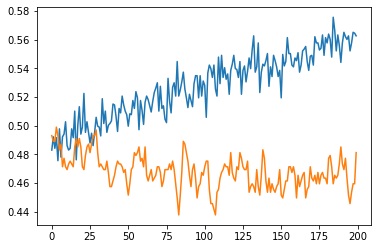

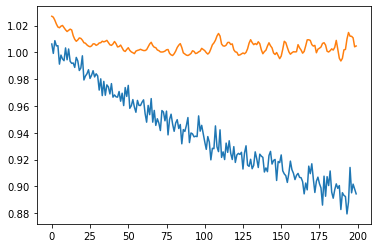

In [110]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

In [111]:
model.load_weights(checkpoint_filepath)
model_path = '/mnt/sda1/shivam/Thesis/Grasp Experiment/Data/Models/model-open-close-no-grasp-bal'
model.save(model_path)

26-Dec-22 15:57:42 | WARNING | Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


In [112]:
new_model = tf.keras.models.load_model(model_path)

y_pred = np.argmax(new_model.predict(X_test), axis=1)  # Softmax
# y_pred = [1 if x > 0.5 else 0 for x in new_model.predict(X_test)]  # Sigmoid

y_true = y_test
test_acc = sum(y_pred == y_true) / len(y_true)

print("Max train accuracy: ", max(history.history["accuracy"]))
print("Max validation accuracy: ", max(history.history["val_accuracy"]))
print(f'Test set accuracy: {test_acc:.0%}')

13/13 [==============================] - 0s 2ms/step
Max train accuracy:  0.5755706429481506
Max validation accuracy:  0.4990138113498688
Test set accuracy: 48%


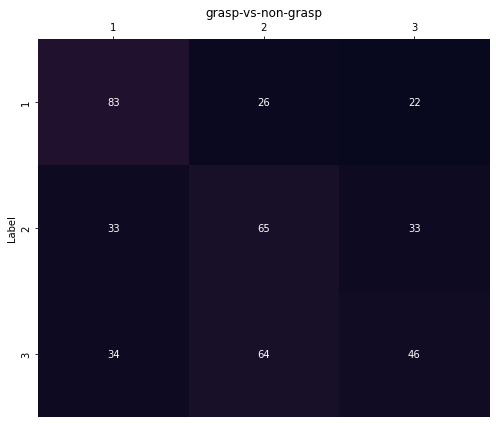

In [113]:
confusion_matrix = tf.math.confusion_matrix(y_true, y_pred)

plt.figure(figsize = (7,6))
hm1 = sns.heatmap(confusion_matrix, annot=True, cbar=False, vmin=0, vmax=1000,fmt='g')

hm1.set(title='grasp-vs-non-grasp', ylabel='Label')
hm1.xaxis.tick_top()

hm1.set_xticklabels([int(i.get_text())+1 for i in hm1.get_xticklabels()])
hm1.set_yticklabels([int(i.get_text())+1 for i in hm1.get_yticklabels()])
plt.tight_layout()

# hm1.get_figure().savefig(file_name + ".png")

# 4-class classification [PSD]

In [5]:
os.chdir('/mnt/sda1/shivam/Thesis/Grasp Experiment/Data/IntData/')
X, ya, yh = np.load("psd_features_v2_2.npy"), np.load("psd_labels_action_v2_2.npy"), np.load("psd_labels_hand_v2_1.npy")
X.shape, ya.shape, yh.shape # ((1920, 320), (1920,))

((1689, 320), (1689,), (1689,))

In [6]:
def get_classes(yh, ya):
    '''
    yh: y label for hand [left/right]
    ya: y label for action [open/close]
    0: left open
    1: left close
    2: right open
    3: right close
    '''
    if yh == "Left":
        if ya == "Open":
            return 0
        elif ya == "Close":
            return 1
    elif yh == "Right":
        if ya == "Open":
            return 2
        elif ya == "Close":
            return 3

In [7]:
y = np.array([get_classes(yh[i], ya[i]) for i in range(len(yh))])
y, np.unique(y)

(array([2, 0, 3, ..., 2, 1, 3]), array([0, 1, 2, 3]))

In [10]:
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
X_train.shape, X_eval.shape, y_train.shape, y_eval.shape#, y_test.shape

((1351, 320), (338, 320), (1351,), (338,))

In [11]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_eval, y_train, y_eval)

100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


In [12]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
XGBClassifier,0.55,0.55,None,0.55,1.88
LGBMClassifier,0.53,0.53,None,0.53,1.06
NuSVC,0.53,0.53,None,0.52,0.46
RandomForestClassifier,0.52,0.52,None,0.52,1.02
ExtraTreesClassifier,0.50,0.50,None,0.49,0.33
SVC,0.49,0.49,None,0.48,0.44
LinearSVC,0.49,0.49,None,0.48,1.99
CalibratedClassifierCV,0.48,0.48,None,0.48,7.16
BaggingClassifier,0.48,0.48,None,0.48,1.60


# 2-class classification (left and right hand) [PSD]

In [14]:
Xh = X[yh=="Left"]
y = np.array([0 if x == "Open" else 1 for x in ya[yh=="Left"]])
Xh.shape, np.unique(y), y.shape

((845, 320), array([0, 1]), (845,))

In [15]:
X_train, X_eval, y_train, y_eval = train_test_split(Xh, y, test_size=0.2, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
X_train.shape, X_eval.shape, y_train.shape, y_eval.shape#, y_test.shape

((676, 320), (169, 320), (676,), (169,))

In [16]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_eval, y_train, y_eval)
models

100%|███████████████████████████████████████████| 29/29 [00:05<00:00,  5.27it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
BaggingClassifier,0.64,0.63,0.63,0.63,0.76
LogisticRegression,0.63,0.63,0.63,0.63,0.04
ExtraTreesClassifier,0.63,0.63,0.63,0.63,0.21
Perceptron,0.62,0.62,0.62,0.62,0.02
LinearSVC,0.62,0.62,0.62,0.62,0.37
RidgeClassifier,0.61,0.61,0.61,0.61,0.02
RidgeClassifierCV,0.61,0.61,0.61,0.61,0.03
SGDClassifier,0.61,0.61,0.61,0.61,0.03
LinearDiscriminantAnalysis,0.60,0.61,0.61,0.60,0.06


In [17]:
Xh = X[yh=="Right"]
y = np.array([0 if x == "Open" else 1 for x in ya[yh=="Right"]])
Xh.shape, np.unique(y), y.shape

((844, 320), array([0, 1]), (844,))

In [19]:
X_train, X_eval, y_train, y_eval = train_test_split(Xh, y, test_size=0.2, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
X_train.shape, X_eval.shape, y_train.shape, y_eval.shape#, y_test.shape

((675, 320), (169, 320), (675,), (169,))

In [20]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_eval, y_train, y_eval)
models

100%|███████████████████████████████████████████| 29/29 [00:05<00:00,  5.33it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NuSVC,0.58,0.58,0.58,0.58,0.12
ExtraTreeClassifier,0.56,0.56,0.56,0.56,0.02
ExtraTreesClassifier,0.56,0.56,0.56,0.56,0.20
LinearDiscriminantAnalysis,0.55,0.55,0.55,0.55,0.06
RidgeClassifier,0.53,0.53,0.53,0.53,0.02
PassiveAggressiveClassifier,0.53,0.53,0.53,0.52,0.02
KNeighborsClassifier,0.52,0.52,0.52,0.52,0.02
RidgeClassifierCV,0.51,0.51,0.51,0.51,0.04
CalibratedClassifierCV,0.51,0.51,0.51,0.51,1.22


# 4-class classification [EEGNET]
open/close and left/right

In [3]:
os.chdir("/mnt/sda1/shivam/Thesis/Grasp Experiment/Data/CleanSep/")
dataset = pd.read_csv("cleaned_datav2_1.csv")
dataset

,-100,-96,-92,-88,-84,-80,-76,-72,-68,-64,...,1984,1988,1992,1996,handPos,Hand,Action,Subject,Channel,Trial
0,0.992095,1.045134,0.821468,0.452555,0.167359,0.094921,0.189011,0.329643,0.452000,0.571202,...,0.901282,1.205751,1.477981,1.604695,palmDown,Right,Open,P01,E1,1
1,2.327051,1.829087,1.126410,0.539903,0.254767,0.220154,0.275524,0.326122,0.358070,0.339999,...,1.157870,1.758465,2.152331,2.008305,palmDown,Right,Open,P01,E2,1
2,1.469934,0.977102,0.371654,-0.247481,-0.769376,-1.051254,-0.927896,-0.341758,0.494546,1.133734,...,3.734554,2.259370,0.694383,-0.241412,palmDown,Right,Open,P01,E3,1
3,1.174265,0.275177,-0.301046,-0.423238,-0.229120,0.078764,0.419357,0.789833,1.066523,0.971994,...,7.144750,6.395225,5.569899,4.741736,palmDown,Right,Open,P01,E4,1
4,2.255072,1.371588,0.617765,0.299977,0.366954,0.458520,0.244992,-0.272633,-0.790045,-1.003268,...,-4.013077,-3.801898,-3.589362,-3.451835,palmDown,Right,Open,P01,E5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108091,-2.445500,-2.086449,-1.664462,-1.327237,-1.056840,-0.698166,-0.149868,0.481527,0.934734,1.021945,...,-1.330102,-1.402885,-1.321180,-0.956493,palmIn,Right,Close,P02,E60,40
108092,0.511842,1.063752,1.393768,1.416486,1.297928,1.233769,1.234531,1.145647,0.854900,0.458262,...,1.366183,1.299774,1.526909,1.850113,palmIn,Right,Close,P02,E61,40
108093,0.785885,1.405320,1.803924,1.812186,1.511671,1.110243,0.762582,0.506878,0.334063,0.261710,...,0.239424,0.140736,0.363589,0.694644,palmIn,Right,Close,P02,E62,40
108094,-0.180746,0.308578,0.770090,1.049912,1.227704,1.427121,1.629657,1.660632,1.356432,0.750337,...,-5.226360,-5.124567,-4.040935,-2.711169,palmIn,Right,Close,P02,E63,40


In [7]:
# 64 channel EEG data with 500 samples
# Giving us X = N * 64 * 275 and y = N 
X, yh, ya = [], [], []
nchan = 64
# new_dataset = dataset[~(dataset["Subject"] == "P01")]
iterations = len(dataset) // nchan
for idx in range(iterations):
    start = idx * nchan
    end = (idx + 1) * nchan

    X.append(np.expand_dims(dataset.iloc[start: end, :-6], 2))
    yh.append(dataset.iloc[start, -5])
    ya.append(dataset.iloc[start, -4])
#     print(len(X), len(y))

X = np.array(X)
yh = np.array(yh)
ya = np.array(ya)
X.shape, yh.shape, ya.shape

((1689, 64, 525, 1), (1689,), (1689,))

In [12]:
def get_classes(yh, ya):
    '''
    yh: y label for hand [left/right]
    ya: y label for action [open/close]
    0: left open
    1: left close
    2: right open
    3: right close
    '''
    if yh == "Left":
        if ya == "Open":
            return 0
        elif ya == "Close":
            return 1
    elif yh == "Right":
        if ya == "Open":
            return 2
        elif ya == "Close":
            return 3

In [15]:
y = np.array([get_classes(yh[i], ya[i]) for i in range(len(yh))])
y, np.unique(y)

(array([2, 0, 3, ..., 2, 1, 3]), array([0, 1, 2, 3]))

In [16]:
X_train, X_eval, y_train, y_eval = train_test_split(X[:, :, 60:124, 0], y, test_size=0.25, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
X_train.shape, X_eval.shape, X_test.shape, y_train.shape, y_eval.shape, y_test.shape

((949, 64, 64), (423, 64, 64), (317, 64, 64), (949,), (423,), (317,))

In [48]:
# https://github.com/vlawhern/arl-eegmodels
def EEGNet(nb_classes, Chans = 64, Samples = 128, 
             dropoutRate = 0.7, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    """ Keras Implementation of EEGNet
    http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta
    Note that this implements the newest version of EEGNet and NOT the earlier
    version (version v1 and v2 on arxiv). We strongly recommend using this
    architecture as it performs much better and has nicer properties than
    our earlier version. For example:
        
        1. Depthwise Convolutions to learn spatial filters within a 
        temporal convolution. The use of the depth_multiplier option maps 
        exactly to the number of spatial filters learned within a temporal
        filter. This matches the setup of algorithms like FBCSP which learn 
        spatial filters within each filter in a filter-bank. This also limits 
        the number of free parameters to fit when compared to a fully-connected
        convolution. 
        
        2. Separable Convolutions to learn how to optimally combine spatial
        filters across temporal bands. Separable Convolutions are Depthwise
        Convolutions followed by (1x1) Pointwise Convolutions. 
        
    
    While the original paper used Dropout, we found that SpatialDropout2D 
    sometimes produced slightly better results for classification of ERP 
    signals. However, SpatialDropout2D significantly reduced performance 
    on the Oscillatory dataset (SMR, BCI-IV Dataset 2A). We recommend using
    the default Dropout in most cases.
        
    Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and average pooling size in blocks 1 and 2 as needed (double the 
    kernel lengths for double the sampling rate, etc). Note that we haven't 
    tested the model performance with this rule so this may not work well. 
    
    The model with default parameters gives the EEGNet-8,2 model as discussed
    in the paper. This model should do pretty well in general, although it is
	advised to do some model searching to get optimal performance on your
	particular dataset.
    We set F2 = F1 * D (number of input filters = number of output filters) for
    the SeparableConv2D layer. We haven't extensively tested other values of this
    parameter (say, F2 < F1 * D for compressed learning, and F2 > F1 * D for
    overcomplete). We believe the main parameters to focus on are F1 and D. 
    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.     
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D. 
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.
    """
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)

model = EEGNet(4, 64, 64)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 8)         512       
                                                                 
 batch_normalization_21 (Bat  (None, 64, 64, 8)        32        
 chNormalization)                                                
                                                                 
 depthwise_conv2d_7 (Depthwi  (None, 1, 64, 16)        1024      
 seConv2D)                                                       
                                                                 
 batch_normalization_22 (Bat  (None, 1, 64, 16)        64        
 chNormalization)                                                
                                                           

In [49]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', 
              metrics = ['accuracy'])

# count number of parameters in the model
numParams = model.count_params()    

# set a valid path for your system to record model checkpoints
checkpoint_filepath = "/tmp/checkpoint/"
checkpointer = ModelCheckpoint(
        filepath=checkpoint_filepath, 
        save_weights_only=True,
        monitor="val_accuracy",
        mode="max",
        save_best_only=True
)

# Handle class imbalance
class_weights = {0:1, 1:1}

In [50]:
np.unique(y_train)

array([0, 1, 2, 3])

In [51]:
################################################################################
# fit the model. Due to very small sample sizes this can get
# pretty noisy run-to-run, but most runs should be comparable to xDAWN + 
# Riemannian geometry classification (below)
################################################################################
batch_size = 512
EPOCHS = 200
history = model.fit(
    X_train, 
    y_train, 
    batch_size = batch_size, 
    epochs = EPOCHS, 
    validation_data=(X_eval, y_eval),
    callbacks=[checkpointer], 
#     class_weight = class_weights
)

Epoch 1/200
2/2 [==============================] - 1s 228ms/step - loss: 1.5483 - accuracy: 0.2666 - val_loss: 1.3831 - val_accuracy: 0.3688
Epoch 2/200
2/2 [==============================] - 0s 90ms/step - loss: 1.3957 - accuracy: 0.2550 - val_loss: 1.3815 - val_accuracy: 0.3806
Epoch 3/200
2/2 [==============================] - 0s 74ms/step - loss: 1.3728 - accuracy: 0.3024 - val_loss: 1.3799 - val_accuracy: 0.3948
Epoch 4/200
2/2 [==============================] - 0s 41ms/step - loss: 1.3768 - accuracy: 0.2666 - val_loss: 1.3781 - val_accuracy: 0.3877
Epoch 5/200
2/2 [==============================] - 0s 49ms/step - loss: 1.3612 - accuracy: 0.3319 - val_loss: 1.3760 - val_accuracy: 0.3783
Epoch 6/200
2/2 [==============================] - 0s 46ms/step - loss: 1.3511 - accuracy: 0.3488 - val_loss: 1.3735 - val_accuracy: 0.3830
Epoch 7/200
2/2 [==============================] - 0s 46ms/step - loss: 1.3538 - accuracy: 0.3182 - val_loss: 1.3704 - val_accuracy: 0.3901
Epoch 8/200
2/2 [==

2/2 [==============================] - 0s 44ms/step - loss: 0.9919 - accuracy: 0.4921 - val_loss: 0.9613 - val_accuracy: 0.4279
Epoch 118/200
2/2 [==============================] - 0s 46ms/step - loss: 0.9939 - accuracy: 0.4900 - val_loss: 0.9613 - val_accuracy: 0.4279
Epoch 119/200
2/2 [==============================] - 0s 44ms/step - loss: 0.9926 - accuracy: 0.4742 - val_loss: 0.9611 - val_accuracy: 0.4326
Epoch 120/200
2/2 [==============================] - 0s 43ms/step - loss: 0.9926 - accuracy: 0.4921 - val_loss: 0.9609 - val_accuracy: 0.4326
Epoch 121/200
2/2 [==============================] - 0s 42ms/step - loss: 0.9895 - accuracy: 0.4679 - val_loss: 0.9608 - val_accuracy: 0.4279
Epoch 122/200
2/2 [==============================] - 0s 47ms/step - loss: 0.9886 - accuracy: 0.5079 - val_loss: 0.9605 - val_accuracy: 0.4350
Epoch 123/200
2/2 [==============================] - 0s 44ms/step - loss: 0.9885 - accuracy: 0.4679 - val_loss: 0.9605 - val_accuracy: 0.4374
Epoch 124/200
2/2 [=

Epoch 175/200
2/2 [==============================] - 0s 44ms/step - loss: 0.9673 - accuracy: 0.5026 - val_loss: 0.9523 - val_accuracy: 0.4421
Epoch 176/200
2/2 [==============================] - 0s 63ms/step - loss: 0.9558 - accuracy: 0.4837 - val_loss: 0.9533 - val_accuracy: 0.4421
Epoch 177/200
2/2 [==============================] - 0s 41ms/step - loss: 0.9513 - accuracy: 0.4910 - val_loss: 0.9544 - val_accuracy: 0.4397
Epoch 178/200
2/2 [==============================] - 0s 44ms/step - loss: 0.9568 - accuracy: 0.4974 - val_loss: 0.9549 - val_accuracy: 0.4350
Epoch 179/200
2/2 [==============================] - 0s 51ms/step - loss: 0.9609 - accuracy: 0.4605 - val_loss: 0.9547 - val_accuracy: 0.4326
Epoch 180/200
2/2 [==============================] - 0s 47ms/step - loss: 0.9540 - accuracy: 0.4900 - val_loss: 0.9544 - val_accuracy: 0.4326
Epoch 181/200
2/2 [==============================] - 0s 44ms/step - loss: 0.9515 - accuracy: 0.5026 - val_loss: 0.9543 - val_accuracy: 0.4255
Epoch 

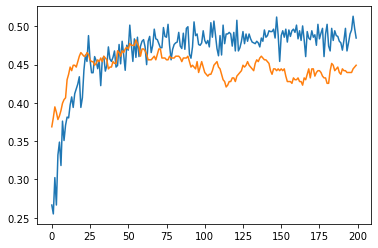

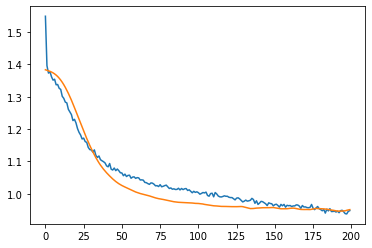

In [52]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

In [54]:
model.load_weights(checkpoint_filepath)
model_path = '/mnt/sda1/shivam/Thesis/Grasp Experiment/Data/Models/model-eegnet-4-class-v2'
model.save(model_path)

24-Dec-22 18:05:49 | WARNING | Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


Max train accuracy:  0.5131717324256897
Max validation accuracy:  0.4822694957256317


In [55]:
new_model = tf.keras.models.load_model(model_path)

y_pred = np.argmax(new_model.predict(X_test), axis=1)
y_true = y_test
test_acc = sum(y_pred == y_true) / len(y_true)
print("Max train accuracy: ", max(history.history["accuracy"]))
print("Max validation accuracy: ", max(history.history["val_accuracy"]))
print(f'Test set accuracy: {test_acc:.0%}')

10/10 [==============================] - 0s 2ms/step
Test set accuracy: 41%


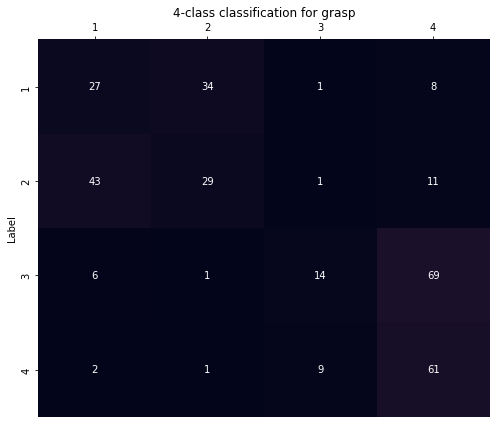

In [56]:
confusion_matrix = tf.math.confusion_matrix(y_true, y_pred)

plt.figure(figsize = (7,6))
hm1 = sns.heatmap(confusion_matrix, annot=True, cbar=False, vmin=0, vmax=1000,fmt='g')

hm1.set(title='4-class classification for grasp', ylabel='Label')
hm1.xaxis.tick_top()

hm1.set_xticklabels([int(i.get_text())+1 for i in hm1.get_xticklabels()])
hm1.set_yticklabels([int(i.get_text())+1 for i in hm1.get_yticklabels()])
plt.tight_layout()

# hm1.get_figure().savefig(file_name + ".png")

# Left and Right open/close [EEGNET]

In [5]:
os.chdir("/mnt/sda1/shivam/Thesis/Grasp Experiment/Data/CleanSep/")
dataset = pd.read_csv("cleaned_datav2_1.csv")
dataset

,-100,-96,-92,-88,-84,-80,-76,-72,-68,-64,...,1984,1988,1992,1996,handPos,Hand,Action,Subject,Channel,Trial
0,0.99,1.05,0.82,0.45,0.17,0.09,0.19,0.33,0.45,0.57,...,0.90,1.21,1.48,1.60,palmDown,Right,Open,P01,E1,1
1,2.33,1.83,1.13,0.54,0.25,0.22,0.28,0.33,0.36,0.34,...,1.16,1.76,2.15,2.01,palmDown,Right,Open,P01,E2,1
2,1.47,0.98,0.37,-0.25,-0.77,-1.05,-0.93,-0.34,0.49,1.13,...,3.73,2.26,0.69,-0.24,palmDown,Right,Open,P01,E3,1
3,1.17,0.28,-0.30,-0.42,-0.23,0.08,0.42,0.79,1.07,0.97,...,7.14,6.40,5.57,4.74,palmDown,Right,Open,P01,E4,1
4,2.26,1.37,0.62,0.30,0.37,0.46,0.24,-0.27,-0.79,-1.00,...,-4.01,-3.80,-3.59,-3.45,palmDown,Right,Open,P01,E5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108091,-2.45,-2.09,-1.66,-1.33,-1.06,-0.70,-0.15,0.48,0.93,1.02,...,-1.33,-1.40,-1.32,-0.96,palmIn,Right,Close,P02,E60,40
108092,0.51,1.06,1.39,1.42,1.30,1.23,1.23,1.15,0.85,0.46,...,1.37,1.30,1.53,1.85,palmIn,Right,Close,P02,E61,40
108093,0.79,1.41,1.80,1.81,1.51,1.11,0.76,0.51,0.33,0.26,...,0.24,0.14,0.36,0.69,palmIn,Right,Close,P02,E62,40
108094,-0.18,0.31,0.77,1.05,1.23,1.43,1.63,1.66,1.36,0.75,...,-5.23,-5.12,-4.04,-2.71,palmIn,Right,Close,P02,E63,40


In [6]:
# 64 channel EEG data with 500 samples
# Giving us X = N * 64 * 275 and y = N 
X, yh, ya = [], [], []
nchan = 64
# new_dataset = dataset[~(dataset["Subject"] == "P01")]
iterations = len(dataset) // nchan
for idx in range(iterations):
    start = idx * nchan
    end = (idx + 1) * nchan

    X.append(np.expand_dims(dataset.iloc[start: end, :-6], 2))
    yh.append(dataset.iloc[start, -5])
    ya.append(dataset.iloc[start, -4])
#     print(len(X), len(y))

X = np.array(X)
yh = np.array(yh)
ya = np.array(ya)
X.shape, yh.shape, ya.shape

((1689, 64, 525, 1), (1689,), (1689,))

In [32]:
Xh = X[yh=="Right"][:, :, :, 0]
y = np.array([0 if x == "Open" else 1 for x in ya[yh=="Right"]])
Xh.shape, np.unique(y), y.shape

((844, 64, 525), array([0, 1]), (844,))

In [33]:
X_train, X_eval, y_train, y_eval = train_test_split(Xh, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train.shape, X_eval.shape, X_test.shape, y_train.shape, y_eval.shape, y_test.shape

((540, 64, 525), (169, 64, 525), (135, 64, 525), (540,), (169,), (135,))

In [34]:
# https://github.com/vlawhern/arl-eegmodels
def EEGNet(nb_classes, Chans = 64, Samples = 128, 
             dropoutRate = 0.8, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('sigmoid', name = 'sigmoid')(dense)
    
    return Model(inputs=input1, outputs=softmax)

model = EEGNet(1, 64, 525)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 525, 1)]      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 525, 8)        512       
                                                                 
 batch_normalization_9 (Batc  (None, 64, 525, 8)       32        
 hNormalization)                                                 
                                                                 
 depthwise_conv2d_3 (Depthwi  (None, 1, 525, 16)       1024      
 seConv2D)                                                       
                                                                 
 batch_normalization_10 (Bat  (None, 1, 525, 16)       64        
 chNormalization)                                                
                                                           

In [35]:
model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics = ['accuracy'])

# count number of parameters in the model
numParams = model.count_params()    

# set a valid path for your system to record model checkpoints
checkpoint_filepath = "/tmp/checkpoint/"
checkpointer = ModelCheckpoint(
        filepath=checkpoint_filepath, 
        save_weights_only=True,
        monitor="val_accuracy",
        mode="max",
        save_best_only=True
)

# Handle class imbalance
class_weights = {0:1, 1:1}

In [36]:
################################################################################
# fit the model. Due to very small sample sizes this can get
# pretty noisy run-to-run, but most runs should be comparable to xDAWN + 
# Riemannian geometry classification (below)
################################################################################
batch_size = 512
EPOCHS = 200
history = model.fit(
    X_train, 
    y_train, 
    batch_size = batch_size, 
    epochs = EPOCHS, 
    validation_data=(X_eval, y_eval),
    callbacks=[checkpointer], 
#     class_weight = class_weights
)

Epoch 1/200
2/2 [==============================] - 1s 241ms/step - loss: 0.7898 - accuracy: 0.5130 - val_loss: 0.6928 - val_accuracy: 0.5266
Epoch 2/200
2/2 [==============================] - 0s 64ms/step - loss: 0.6864 - accuracy: 0.5370 - val_loss: 0.6928 - val_accuracy: 0.5207
Epoch 3/200
2/2 [==============================] - 0s 50ms/step - loss: 0.6936 - accuracy: 0.5000 - val_loss: 0.6928 - val_accuracy: 0.5207
Epoch 4/200
2/2 [==============================] - 0s 40ms/step - loss: 0.6974 - accuracy: 0.5185 - val_loss: 0.6929 - val_accuracy: 0.5266
Epoch 5/200
2/2 [==============================] - 0s 47ms/step - loss: 0.6993 - accuracy: 0.5204 - val_loss: 0.6929 - val_accuracy: 0.5207
Epoch 6/200
2/2 [==============================] - 0s 48ms/step - loss: 0.6953 - accuracy: 0.5130 - val_loss: 0.6929 - val_accuracy: 0.5030
Epoch 7/200
2/2 [==============================] - 0s 54ms/step - loss: 0.6941 - accuracy: 0.5241 - val_loss: 0.6929 - val_accuracy: 0.5089
Epoch 8/200
2/2 [==

2/2 [==============================] - 0s 48ms/step - loss: 0.6302 - accuracy: 0.6296 - val_loss: 0.6963 - val_accuracy: 0.5680
Epoch 118/200
2/2 [==============================] - 0s 49ms/step - loss: 0.6370 - accuracy: 0.6407 - val_loss: 0.6970 - val_accuracy: 0.5621
Epoch 119/200
2/2 [==============================] - 0s 52ms/step - loss: 0.6432 - accuracy: 0.6185 - val_loss: 0.6974 - val_accuracy: 0.5740
Epoch 120/200
2/2 [==============================] - 0s 48ms/step - loss: 0.6285 - accuracy: 0.6315 - val_loss: 0.6975 - val_accuracy: 0.5680
Epoch 121/200
2/2 [==============================] - 0s 44ms/step - loss: 0.6384 - accuracy: 0.6315 - val_loss: 0.6971 - val_accuracy: 0.5740
Epoch 122/200
2/2 [==============================] - 0s 48ms/step - loss: 0.6360 - accuracy: 0.6370 - val_loss: 0.6969 - val_accuracy: 0.5799
Epoch 123/200
2/2 [==============================] - 0s 46ms/step - loss: 0.6383 - accuracy: 0.6333 - val_loss: 0.6964 - val_accuracy: 0.5799
Epoch 124/200
2/2 [=

Epoch 175/200
2/2 [==============================] - 0s 47ms/step - loss: 0.6091 - accuracy: 0.6556 - val_loss: 0.7356 - val_accuracy: 0.5503
Epoch 176/200
2/2 [==============================] - 0s 47ms/step - loss: 0.6063 - accuracy: 0.6815 - val_loss: 0.7325 - val_accuracy: 0.5621
Epoch 177/200
2/2 [==============================] - 0s 47ms/step - loss: 0.6129 - accuracy: 0.6833 - val_loss: 0.7293 - val_accuracy: 0.5680
Epoch 178/200
2/2 [==============================] - 0s 49ms/step - loss: 0.6254 - accuracy: 0.6500 - val_loss: 0.7275 - val_accuracy: 0.5621
Epoch 179/200
2/2 [==============================] - 0s 46ms/step - loss: 0.6090 - accuracy: 0.6667 - val_loss: 0.7270 - val_accuracy: 0.5562
Epoch 180/200
2/2 [==============================] - 0s 47ms/step - loss: 0.6182 - accuracy: 0.6685 - val_loss: 0.7271 - val_accuracy: 0.5562
Epoch 181/200
2/2 [==============================] - 0s 51ms/step - loss: 0.6100 - accuracy: 0.6574 - val_loss: 0.7283 - val_accuracy: 0.5562
Epoch 

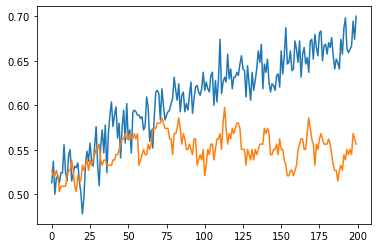

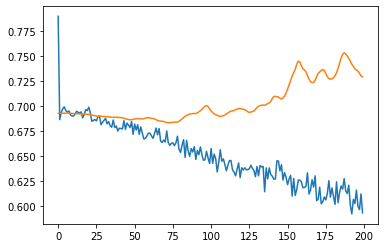

In [37]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

In [38]:
model.load_weights(checkpoint_filepath)
model_path = '/mnt/sda1/shivam/Thesis/Grasp Experiment/Data/Models/model-eegnet-right-2-class-v2'
model.save(model_path)

26-Dec-22 11:30:32 | WARNING | Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


In [39]:
new_model = tf.keras.models.load_model(model_path)

# y_pred = np.argmax(new_model.predict(X_test), axis=1)  # Softmax
y_pred = [1 if x > 0.5 else 0 for x in new_model.predict(X_test)]  # Sigmoid

y_true = y_test
test_acc = sum(y_pred == y_true) / len(y_true)
print("Max train accuracy: ", max(history.history["accuracy"]))
print("Max validation accuracy: ", max(history.history["val_accuracy"]))
print(f'Test set accuracy: {test_acc:.0%}')

5/5 [==============================] - 0s 9ms/step
Max train accuracy:  0.699999988079071
Max validation accuracy:  0.5976331233978271
Test set accuracy: 56%


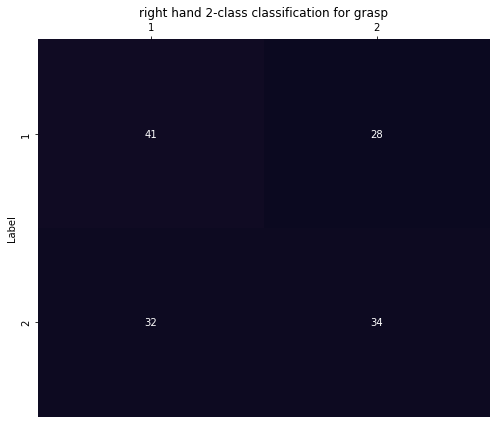

In [40]:
confusion_matrix = tf.math.confusion_matrix(y_true, y_pred)

plt.figure(figsize = (7,6))
hm1 = sns.heatmap(confusion_matrix, annot=True, cbar=False, vmin=0, vmax=1000,fmt='g')

hm1.set(title='right hand 2-class classification for grasp', ylabel='Label')
hm1.xaxis.tick_top()

hm1.set_xticklabels([int(i.get_text())+1 for i in hm1.get_xticklabels()])
hm1.set_yticklabels([int(i.get_text())+1 for i in hm1.get_yticklabels()])
plt.tight_layout()

# hm1.get_figure().savefig(file_name + ".png")

# HCTSA

In [2]:
os.chdir("/mnt/sda1/shivam/Thesis/Grasp Experiment/Data/CleanSep/")
dataset = pd.read_csv("cleaned_datav2_1.csv")
dataset

,-100,-96,-92,-88,-84,-80,-76,-72,-68,-64,...,1984,1988,1992,1996,handPos,Hand,Action,Subject,Channel,Trial
0,0.992095,1.045134,0.821468,0.452555,0.167359,0.094921,0.189011,0.329643,0.452000,0.571202,...,0.901282,1.205751,1.477981,1.604695,palmDown,Right,Open,P01,E1,1
1,2.327051,1.829087,1.126410,0.539903,0.254767,0.220154,0.275524,0.326122,0.358070,0.339999,...,1.157870,1.758465,2.152331,2.008305,palmDown,Right,Open,P01,E2,1
2,1.469934,0.977102,0.371654,-0.247481,-0.769376,-1.051254,-0.927896,-0.341758,0.494546,1.133734,...,3.734554,2.259370,0.694383,-0.241412,palmDown,Right,Open,P01,E3,1
3,1.174265,0.275177,-0.301046,-0.423238,-0.229120,0.078764,0.419357,0.789833,1.066523,0.971994,...,7.144750,6.395225,5.569899,4.741736,palmDown,Right,Open,P01,E4,1
4,2.255072,1.371588,0.617765,0.299977,0.366954,0.458520,0.244992,-0.272633,-0.790045,-1.003268,...,-4.013077,-3.801898,-3.589362,-3.451835,palmDown,Right,Open,P01,E5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108091,-2.445500,-2.086449,-1.664462,-1.327237,-1.056840,-0.698166,-0.149868,0.481527,0.934734,1.021945,...,-1.330102,-1.402885,-1.321180,-0.956493,palmIn,Right,Close,P02,E60,40
108092,0.511842,1.063752,1.393768,1.416486,1.297928,1.233769,1.234531,1.145647,0.854900,0.458262,...,1.366183,1.299774,1.526909,1.850113,palmIn,Right,Close,P02,E61,40
108093,0.785885,1.405320,1.803924,1.812186,1.511671,1.110243,0.762582,0.506878,0.334063,0.261710,...,0.239424,0.140736,0.363589,0.694644,palmIn,Right,Close,P02,E62,40
108094,-0.180746,0.308578,0.770090,1.049912,1.227704,1.427121,1.629657,1.660632,1.356432,0.750337,...,-5.226360,-5.124567,-4.040935,-2.711169,palmIn,Right,Close,P02,E63,40


In [3]:
test_sub_trial = dataset[(dataset["handPos"] == "palmDown") & (dataset["Action"] == "Open") & (dataset["Hand"] == "Right") & (dataset["Trial"] == 1) & (dataset["Subject"] == "P01")]
test_sub_trial

,-100,-96,-92,-88,-84,-80,-76,-72,-68,-64,...,1984,1988,1992,1996,handPos,Hand,Action,Subject,Channel,Trial
0,0.992095,1.045134,0.821468,0.452555,0.167359,0.094921,0.189011,0.329643,0.452000,0.571202,...,0.901282,1.205751,1.477981,1.604695,palmDown,Right,Open,P01,E1,1
1,2.327051,1.829087,1.126410,0.539903,0.254767,0.220154,0.275524,0.326122,0.358070,0.339999,...,1.157870,1.758465,2.152331,2.008305,palmDown,Right,Open,P01,E2,1
2,1.469934,0.977102,0.371654,-0.247481,-0.769376,-1.051254,-0.927896,-0.341758,0.494546,1.133734,...,3.734554,2.259370,0.694383,-0.241412,palmDown,Right,Open,P01,E3,1
3,1.174265,0.275177,-0.301046,-0.423238,-0.229120,0.078764,0.419357,0.789833,1.066523,0.971994,...,7.144750,6.395225,5.569899,4.741736,palmDown,Right,Open,P01,E4,1
4,2.255072,1.371588,0.617765,0.299977,0.366954,0.458520,0.244992,-0.272633,-0.790045,-1.003268,...,-4.013077,-3.801898,-3.589362,-3.451835,palmDown,Right,Open,P01,E5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,1.905059,0.460700,-0.387477,-0.540445,-0.348365,-0.214661,-0.217443,-0.101795,0.373846,1.104117,...,5.752568,4.734868,3.859910,3.435107,palmDown,Right,Open,P01,E60,1
60,0.555476,1.105504,1.127578,0.780944,0.407274,0.252536,0.308282,0.419399,0.469176,0.460792,...,0.933837,2.115797,2.764337,2.626407,palmDown,Right,Open,P01,E61,1
61,0.510115,1.445716,1.096902,0.030402,-0.750039,-0.675852,-0.012465,0.514922,0.410412,-0.225917,...,2.116887,3.559498,3.888156,3.077469,palmDown,Right,Open,P01,E62,1
62,-1.310458,-0.367753,0.113910,-0.190210,-0.941036,-1.404170,-1.078486,-0.119077,0.833298,1.210854,...,-3.597698,-2.152929,-0.826637,-0.429039,palmDown,Right,Open,P01,E63,1


In [4]:
list(test_sub_trial.iloc[0:, :-6].to_numpy()) 

[array([ 9.92094520e-01,  1.04513438e+00,  8.21467766e-01,  4.52555066e-01,
         1.67358641e-01,  9.49209835e-02,  1.89011106e-01,  3.29643487e-01,
         4.51999508e-01,  5.71201602e-01,  6.99322834e-01,  7.77556639e-01,
         7.32790212e-01,  5.78258445e-01,  4.34002533e-01,  4.20128611e-01,
         5.16023896e-01,  5.51458712e-01,  3.51027804e-01, -1.04368090e-01,
        -6.65134622e-01, -1.16207253e+00, -1.55601446e+00, -1.91722005e+00,
        -2.27196587e+00, -2.49918112e+00, -2.41136762e+00, -1.95031275e+00,
        -1.30559449e+00, -8.01383682e-01, -6.54334292e-01, -8.25565856e-01,
        -1.10308676e+00, -1.30995168e+00, -1.41887464e+00, -1.47881246e+00,
        -1.47022765e+00, -1.27592036e+00, -8.22540421e-01, -2.33350240e-01,
         2.04806644e-01,  2.79284996e-01,  5.62959037e-02, -1.81090856e-01,
        -2.13077403e-01, -1.12408287e-01, -1.78212519e-01, -6.17598869e-01,
        -1.29280220e+00, -1.80703129e+00, -1.86050496e+00, -1.54918957e+00,
        -1.2

In [5]:
import pycatch22
tsData = list(test_sub_trial.iloc[0, :-6].to_numpy()) # (or more interesting data!)
pycatch22.CO_f1ecac(tsData)

14.45946061640141

In [6]:
pycatch22.catch22_all(tsData)

{'names': ['DN_HistogramMode_5',
  'DN_HistogramMode_10',
  'CO_f1ecac',
  'CO_FirstMin_ac',
  'CO_HistogramAMI_even_2_5',
  'CO_trev_1_num',
  'MD_hrv_classic_pnn40',
  'SB_BinaryStats_mean_longstretch1',
  'SB_TransitionMatrix_3ac_sumdiagcov',
  'PD_PeriodicityWang_th0_01',
  'CO_Embed2_Dist_tau_d_expfit_meandiff',
  'IN_AutoMutualInfoStats_40_gaussian_fmmi',
  'FC_LocalSimple_mean1_tauresrat',
  'DN_OutlierInclude_p_001_mdrmd',
  'DN_OutlierInclude_n_001_mdrmd',
  'SP_Summaries_welch_rect_area_5_1',
  'SB_BinaryStats_diff_longstretch0',
  'SB_MotifThree_quantile_hh',
  'SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1',
  'SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1',
  'SP_Summaries_welch_rect_centroid',
  'FC_LocalSimple_mean3_stderr'],
 'values': [0.32589285880178753,
  -0.0034971813004345265,
  14.45946061640141,
  36,
  0.5039131951608611,
  0.01210436890551798,
  0.8606870229007634,
  53.0,
  0.08641975308641975,
  126,
  0.574251902612879,
  35.0,
  0.05660377358490566,
  -0.4723809523

In [ ]:
'''
Create MAT file for HCTSA
1. labels: unique identifier for the data point. (NxM)
2. timeSeriesData: time-series data. (Nx1)
3. keywords: class label(open/close). (Nx1)
'''

In [7]:
#1. timeSeriesData
def save_time_series_mat(dataset):
    subjects = list(np.unique(list(dataset.iloc[:, -3])))
    conditions = list(np.unique(list(dataset.iloc[:, -6])))
    
    labels = np.array([], dtype=object)
    keywords = np.array([], dtype=object)
    
    for sub in subjects:
        for palm in conditions:
            for oc in ["Open", "Close"]:
                for hand in ["Left", "Right"]:
                    for i in range(40):
                        test_sub_trial = dataset[
                            (dataset["handPos"] == palm) & 
                            (dataset["Action"] == oc) & 
                            (dataset["Hand"] == hand) & 
                            (dataset["Trial"] == i+1) & 
                            (dataset["Subject"] == sub)].iloc[:, :-6]
                        if test_sub_trial.shape != (64, 525):
                            continue
                        print(test_sub_trial.T.shape)
                        savename = str(sub + "_" + palm + "_" + oc + "_" + hand + "_" + str(i+1))
                        labels = np.append(labels, savename)
                        keywords = np.append(keywords, oc)
    return labels, keywords       

os.chdir("/mnt/sda1/shivam/Thesis/Grasp Experiment/Data/HCTSA Analysis")
labels, keywords = save_time_series_mat(dataset)
labels.shape, keywords.shape

(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)


(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)


(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)
(525, 64)


((1689,), (1689,))

In [8]:
labels

array(['P01_palmDown_Open_Left_1', 'P01_palmDown_Open_Left_2',
       'P01_palmDown_Open_Left_3', ..., 'P04_palmUp_Close_Right_20',
       'P04_palmUp_Close_Right_21', 'P04_palmUp_Close_Right_22'],
      dtype=object)

In [18]:
np.mean(np.zeros((525, 64)), axis=1).shape

(525,)

In [21]:
import scipy.io as sio   
import numpy as np

timeSeriesData = np.empty((labels.shape[0], ), dtype=object) 
count = 0
subjects = list(np.unique(list(dataset.iloc[:, -3])))
conditions = list(np.unique(list(dataset.iloc[:, -6])))

for sub in subjects:
    for palm in conditions:
        for oc in ["Open", "Close"]:
            for hand in ["Left", "Right"]:
                for i in range(40):
                    test_sub_trial = dataset[
                        (dataset["handPos"] == palm) & 
                        (dataset["Action"] == oc) & 
                        (dataset["Hand"] == hand) & 
                        (dataset["Trial"] == i+1) & 
                        (dataset["Subject"] == sub)].iloc[:, :-6]
                    if test_sub_trial.shape != (64, 525):
                        continue
#                     print(test_sub_trial.T.shape)
                    timeSeriesData[count] = np.mean(test_sub_trial.to_numpy().T, axis=1)
                    count += 1
                    print(timeSeriesData.shape)

timeSeriesData.shape, labels.shape, keywords.shape

(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)


(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)
(1689,)


((1689,), (1689,), (1689,))

In [22]:
timeSeriesData[90].shape

(525,)

In [23]:
sio.savemat('INP_GRASP_EEG_v3.mat', {'labels': labels, 'timeSeriesData': timeSeriesData, 'keywords': keywords})

In [207]:
toto = np.zeros((2,), dtype=object)
toto[0]={}
toto[1]={}
toto[1]['Site']=['Tataouine']
toto[0] = np.zeros((2,), dtype=object)
# toto[0]['weapon'][0]={}
# toto[0]['weapon'][1]={}
# toto[0]['weapon'][1]['Name']='fleurs'
# toto[0]['weapon'][0]['Name']='bonbons'
toto
sio.savemat('toto1.mat', {'toto':toto})